In [3]:
import xarray as xr
import dask
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import ticker
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import scipy
from scipy import signal
from scipy.optimize import curve_fit
import math
from mpl_toolkits.basemap import Basemap
import statistics 
from scipy.stats.kde import gaussian_kde
from numpy import linspace
bm = Basemap() 

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


In [4]:
#R2 = np.load('/fast/gmooers/RG_Paper_Data/15_Min_Interval_Heat.npy')
R2 = np.load('/fast/gmooers/Real_Geography_Manuscript/Data_For_Paper/Final_July_SHERPA_15_Min_Interval_Heating.npy')
thresh = 0
super_threshold_indices = R2 < thresh
R2[super_threshold_indices] = 0
thresh = 1
super_threshold_indices = R2 > thresh
R2[super_threshold_indices] = 1

Tropical_R = R2[:,40:55,:]
Mid_R = R2[:,64:80,:]

#path_to_file = '/fast/gmooers/Preprocessed_Data/7_Years_Spaced/full_physics_essentials_valid_month02_targets.nc'
path_to_file = '/fast/gmooers/Real_Geography_Manuscript/Preprocessed_Data/Final_July/full_physics_essentials_test_month02_targets.nc'
extra_variables = xr.open_dataset(path_to_file)
truths = extra_variables.targets[:,:30].values

#path_to_file = '/fast/gmooers/Models/Jordan_Best.nc'
path_to_file = '/fast/gmooers/Real_Geography_Manuscript/Models/Final_Sherpa_DNN_July.nc'
extra_variables = xr.open_dataset(path_to_file)
predictions = extra_variables.Prediction[:,:30].values

#path_to_file = '/fast/gmooers/Pickled_Data/Apr_Heat_Seaonal_Avg.nc'
#seasons = xr.open_dataset(path_to_file)
#seasonals = seasons.Prediction.values

x = 144
y = 96
segment = x*y
z = 30
t = int(len(truths)/(x*y))
print(t)
reconstructed_targets = np.zeros(shape=(x, y, t, z))
reconstructed_features = np.zeros(shape=(x, y, t, z))

2975


In [5]:
count = 0
for i in range(t):
    for j in range(y):
        for k in range(x):
            A = truths[count,:]
            B = predictions[count,:]
            reconstructed_targets[k, j, i, :] = A
            reconstructed_features[k, j, i, :] = B
            count = count+1
            
print(reconstructed_targets.shape)
print(reconstructed_features.shape)

(144, 96, 2975, 30)
(144, 96, 2975, 30)


In [6]:
others = netCDF4.Dataset("/fast/gmooers/Raw_Data/extras/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-72000.nc")
plev = np.array(others.variables['lev'])
ps = np.array(others.variables['PS'])
g = 9.81 #m/s^2
#print(plev)
hyai = np.array(others.variables['hyai'])
hybi = np.array(others.variables['hybi'])
#print(hyai.shape)
#print(hyai)
cp = 1004.0
PS = 1e5
P0 = 1e5
P = P0*hyai+PS*hybi # Total pressure [Pa]
dp = P[1:]-P[:-1] # Differential pressure [Pa]
#convert from k/s to w/m^2
reconstructed_targets = reconstructed_targets*dp[None, None, None, :]*cp/g
reconstructed_features = reconstructed_features*dp[None, None, None, :]*cp/g
print('made it')

lat_list = np.linspace(-90.0, 90.0, 96)
lon_list = np.linspace(0.0, 357.5, 144)

#method 1 - Hovmueller Github 
a = 6.37e6 #radius of the earth
dlat = np.abs(lat_list[1]-lat_list[0])
dlon = np.abs(lon_list[0]-lon_list[1])
gridCellWidth = (dlon*np.pi/180.)*a*np.cos(lat_list*np.pi/180.)
reconstructed_targets = reconstructed_targets*gridCellWidth[None,:,None,None]
reconstructed_features = reconstructed_features*gridCellWidth[None,:,None,None]

made it


Function to analyse original time series

In [7]:
def plotting(true, guess, name):
    plt.plot(true, label = 'Truth')
    plt.plot(guess, label = 'Prediction')
    plt.legend()
    plt.xlabel('Days of the Year', fontsize = 20)
    plt.ylabel('Heat Rate in K/s', fontsize = 20)
    #plt.ylim(bottom, top)
    plt.title('Time series for '+name+' location')

Function to get e folding time scale from reconstructed data

In [8]:
def Signal_Test(point_a, point_b, labels):
    fig, ax = plt.subplots()
    plt.title(labels)
    tcoor = np.arange(0, len(point_b), 1)/96
    plt.plot(tcoor, point_a, label="Truth", color = 'blue')
    plt.plot(tcoor, point_b, label = "Prediction", color = 'green')
    it = np.argwhere(np.diff(np.sign(point_a/point_a[0]-np.exp(-1))))[0]
    tau = tcoor[it]
    plt.scatter(tau, np.exp(-1)*point_a[0], s=100, marker = 'H', color = 'orange', label="Truth e-folding time: "+str(round(tau[0],2))+ ' days')
    it = np.argwhere(np.diff(np.sign(point_b/point_b[0]-np.exp(-1))))[0]
    tau = tcoor[it]
    plt.scatter(tau, np.exp(-1)*point_b[0], s=100, marker = 'H', color = 'red', label="Predicted e-folding time: "+str(round(tau[0],2))+ ' days')
    plt.legend()
    plt.xlabel("Time in Days", fontsize = 15)
    plt.show()
    plt.close()

Function to reconstruct and deconstruct time series for anaylsis

In [9]:
def AutoCorr_Point(a):
    a = np.concatenate((a,np.zeros(len(a)-1)))
    A = np.fft.fft(a)
    S = np.conj(A)*A
    c_fourier = np.fft.ifft(S)
    c_fourier = c_fourier[:(c_fourier.size//2)+1]
    return c_fourier

## Small scale point Analysis

Look at 3 points that should be high skill and 3 Points that should be low skill

Are there structural Differences in the Patterns?

The 3 skilled points:

(28N, 175E)
(65S, 250E)
(30S, 90E)

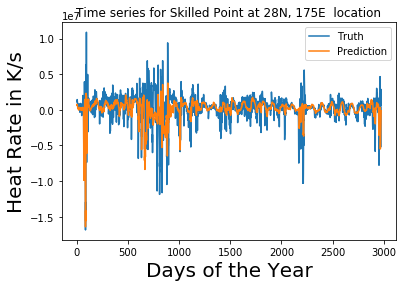

In [10]:
skilled_truth_coord = np.squeeze(reconstructed_targets[70, 62, :,-1])
skilled_predict_coord = np.squeeze(reconstructed_features[70, 62, :,-1])
title = "Skilled Point at 28N, 175E "
plotting(skilled_truth_coord, skilled_predict_coord, title)

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


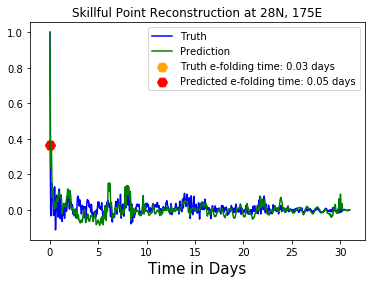

In [11]:
title = 'Skillful Point Reconstruction at 28N, 175E'
truth_test = AutoCorr_Point(skilled_truth_coord)
pred_test = AutoCorr_Point(skilled_predict_coord)
Signal_Test(truth_test/np.max(truth_test), pred_test/np.max(pred_test), title)

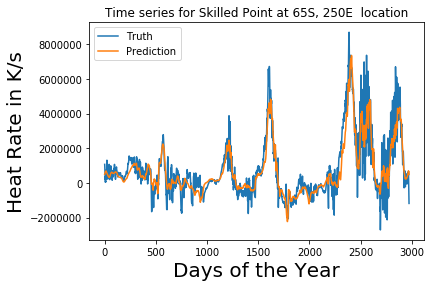

In [12]:
skilled_truth_coord = np.squeeze(reconstructed_targets[100, 13, :,-1])
skilled_predict_coord = np.squeeze(reconstructed_features[100, 13, :,-1])
title = "Skilled Point at 65S, 250E "
plotting(skilled_truth_coord, skilled_predict_coord, title)

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


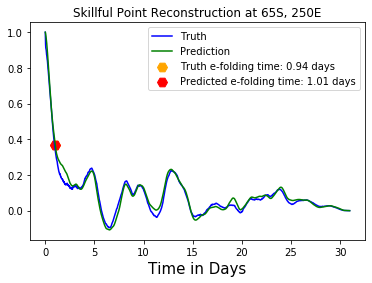

In [13]:
title = 'Skillful Point Reconstruction at 65S, 250E'
truth_test = AutoCorr_Point(skilled_truth_coord)
pred_test = AutoCorr_Point(skilled_predict_coord)
Signal_Test(truth_test/np.max(truth_test), pred_test/np.max(pred_test), title)

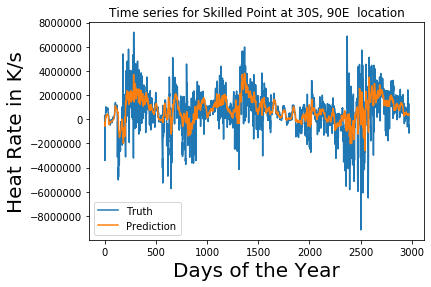

In [14]:
skilled_truth_coord = np.squeeze(reconstructed_targets[36, 32, :,-1])
skilled_predict_coord = np.squeeze(reconstructed_features[36, 32, :,-1])
title = "Skilled Point at 30S, 90E "
plotting(skilled_truth_coord, skilled_predict_coord, title)

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


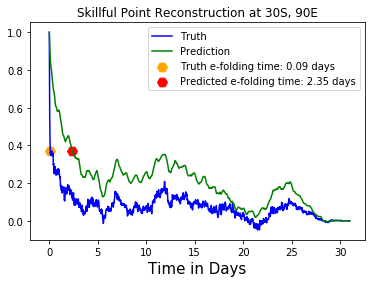

In [15]:
title = 'Skillful Point Reconstruction at 30S, 90E'
truth_test = AutoCorr_Point(skilled_truth_coord)
pred_test = AutoCorr_Point(skilled_predict_coord)
Signal_Test(truth_test/np.max(truth_test), pred_test/np.max(pred_test), title)

The 3 unskilled points:

(0N, 200E)
(10S, 170E)
(S, E)

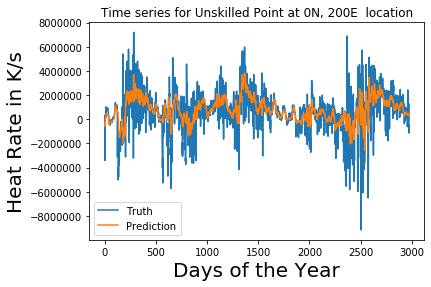

In [16]:
weak_truth_coord = np.squeeze(reconstructed_targets[80, 47, :,-1])
weak_predict_coord = np.squeeze(reconstructed_features[80, 47, :,-1])
title = "Unskilled Point at 0N, 200E "
plotting(skilled_truth_coord, skilled_predict_coord, title)

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


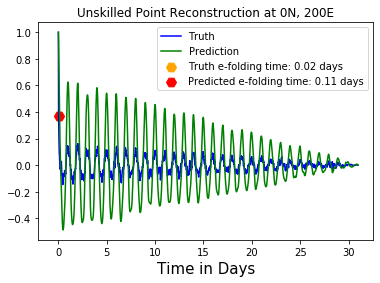

In [17]:
title = 'Unskilled Point Reconstruction at 0N, 200E'
truth_test = AutoCorr_Point(weak_truth_coord)
pred_test = AutoCorr_Point(weak_predict_coord)
Signal_Test(truth_test/np.max(truth_test), pred_test/np.max(pred_test), title)

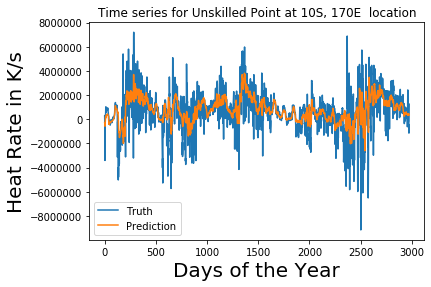

In [18]:
weak_truth_coord = np.squeeze(reconstructed_targets[67, 42, :,-1])
weak_predict_coord = np.squeeze(reconstructed_features[67, 42, :,-1])
title = "Unskilled Point at 10S, 170E "
plotting(skilled_truth_coord, skilled_predict_coord, title)

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


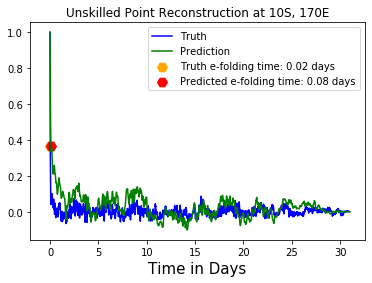

In [19]:
title = 'Unskilled Point Reconstruction at 10S, 170E'
truth_test = AutoCorr_Point(weak_truth_coord)
pred_test = AutoCorr_Point(weak_predict_coord)
Signal_Test(truth_test/np.max(truth_test), pred_test/np.max(pred_test), title)

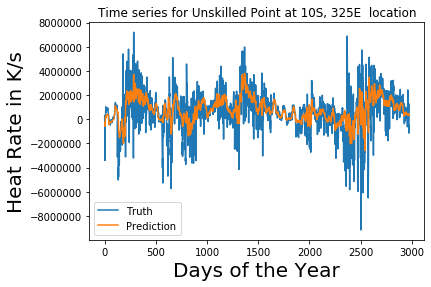

In [20]:
weak_truth_coord = np.squeeze(reconstructed_targets[130, 42, :,-1])
weak_predict_coord = np.squeeze(reconstructed_features[130, 42, :,-1])
title = "Unskilled Point at 10S, 325E "
plotting(skilled_truth_coord, skilled_predict_coord, title)

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


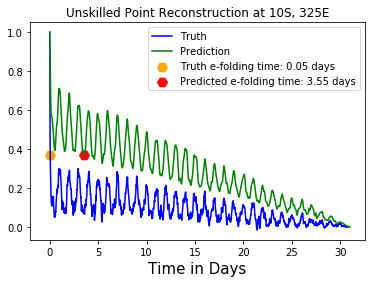

In [21]:
title = 'Unskilled Point Reconstruction at 10S, 325E'
truth_test = AutoCorr_Point(weak_truth_coord)
pred_test = AutoCorr_Point(weak_predict_coord)
Signal_Test(truth_test/np.max(truth_test), pred_test/np.max(pred_test), title)

Generate a reconstruction at each point across the globe.  Will need to debug this likely?

In [22]:
def field_generator(truths, preds):
    corr_truth = np.zeros(shape=(x,y,t,z))
    corr_truth[:,:,:,:] = np.nan
    corr_pred = np.zeros(shape=(x,y,t,z))
    corr_pred[:,:,:] = np.nan
    for i in range(len(corr_truth)):
        for j in range(len(corr_truth[0])):
            for k in range(len(corr_truth[0][0][0])):
                truth_fourier = AutoCorr_Point(truths[i,j,:,k])
                pred_fourier = AutoCorr_Point(preds[i,j,:,k])
                corr_truth[i,j,:,k] = truth_fourier/np.max(truth_fourier)
                corr_pred[i,j,:,k] = pred_fourier/np.max(pred_fourier)
        if i%10==0:
            print(i)
    
    return corr_truth, corr_pred

In [23]:
corr_truth, corr_pred = field_generator(reconstructed_targets, reconstructed_features)

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


## Break into regions, and break down further by skill score

In [24]:
tropical_truths = np.squeeze(corr_truth[:, 40:55, :,:])
tropical_preds = np.squeeze(corr_pred[:, 40:55, :,:])

midlat_truths = np.squeeze(corr_truth[:, 64:80, :,:])
midlat_preds = np.squeeze(corr_pred[:, 64:80, :,:])

In [25]:
def skill_array_generator(data_array, R_array):
    poor_output_array = np.zeros(shape=(x, len(data_array[0]),t, z))
    poor_output_array[:,:,:,:] = np.nan
    good_output_array = np.zeros(shape=(x, len(data_array[0]),t, z))
    good_output_array[:,:,:,:] = np.nan
    good_count = 0
    bad_count = 0
    for i in range(len(data_array)):
        for j in range(len(data_array[i])):
            for k in range(len(data_array[i][j][0])):
                if R_array[i,j,k] >= 0.7:
                    good_output_array[i,j,:,k]=data_array[i,j,:,k]
                    if k == len(data_array[i][j][0]) -1:
                        good_count = good_count+1
                
                if R_array[i,j,k] < 0.3:
                    poor_output_array[i,j,:,k]=data_array[i,j,:,k]
                    if k == len(data_array[i][j][0]) -1:
                        bad_count = bad_count+1
     
    print("Skilled Count is:", good_count, "Unskilled Count is:", bad_count, "Total_Count is:", 144*len(data_array[0]))
    return good_output_array, poor_output_array  

In [26]:
good_tropical_truths, bad_tropical_truths = skill_array_generator(tropical_truths, np.squeeze(Tropical_R))
good_tropical_preds, bad_tropical_preds = skill_array_generator(tropical_preds, np.squeeze(Tropical_R))
good_midlats_truths, bad_midlats_truths = skill_array_generator(midlat_truths, np.squeeze(Mid_R))
good_midlats_preds, bad_midlats_preds = skill_array_generator(midlat_preds, np.squeeze(Mid_R))
all_good_truths, all_bad_truths = skill_array_generator(corr_truth, np.squeeze(R2))
all_good_preds, all_bad_preds = skill_array_generator(corr_pred, np.squeeze(R2))

Skilled Count is: 499 Unskilled Count is: 1321 Total_Count is: 2160
Skilled Count is: 499 Unskilled Count is: 1321 Total_Count is: 2160
Skilled Count is: 1542 Unskilled Count is: 66 Total_Count is: 2304
Skilled Count is: 1542 Unskilled Count is: 66 Total_Count is: 2304
Skilled Count is: 6248 Unskilled Count is: 2492 Total_Count is: 13824
Skilled Count is: 6248 Unskilled Count is: 2492 Total_Count is: 13824


## Alternative method: Get percentiles
- Make a histogram for perspective?
- top 10%?
- bottom 10%?

In [27]:
R_surface =np.squeeze(np.squeeze(R2)[:,:,-1])

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """


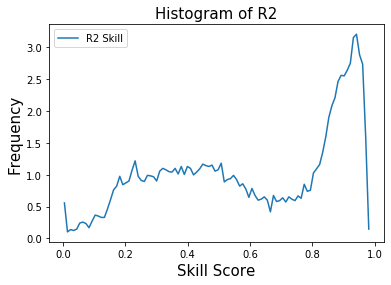

In [28]:
def histo(feats, name):
    f = feats.ravel()
    num_bins = 100
    #change bin specification
    hist, bins = np.histogram(f, num_bins, normed=True)
    bin_centers = (bins[1:]+bins[:-1])*0.5
    plt.plot(bin_centers, hist, label = 'R2 Skill')
    plt.legend(loc='best')
    #plt.xlim(0)
    plt.xlabel('Skill Score', fontsize = 15)
    plt.ylabel('Frequency', fontsize = 15)
    plt.title(name, fontsize = 15)
    #plt.yscale('log')
    #plt.xscale('log')
    #plt.savefig('Figures/Original_Precip_Histogram_1000.png')
    plt.show()

title = "Histogram of R2"
histo(R_surface, title)

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """


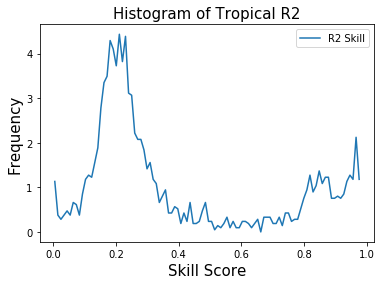

In [29]:
title = "Histogram of Tropical R2"
histo(R_surface[:,40:55], title)

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """


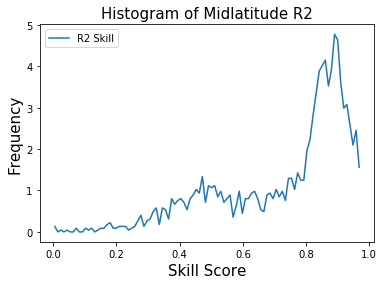

In [30]:
title = "Histogram of Midlatitude R2"
histo(R_surface[:,64:80], title)

## Make a PDF

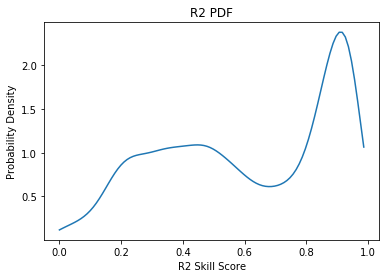

In [31]:
def new_pdf(values, titles):
    R_ravel = values.ravel()
    # this create the kernel, given an array it will estimate the probability over that values
    kde = gaussian_kde(R_ravel)
    # these are the values over wich your kernel will be evaluated
    dist_space = linspace( np.min(R_ravel), np.max(R_ravel), 100)
    plt.plot( dist_space, kde(dist_space) )
    plt.xlabel("R2 Skill Score")
    plt.ylabel("Probability Density")
    plt.title(titles)

title = "R2 PDF"
new_pdf(R_surface, title)

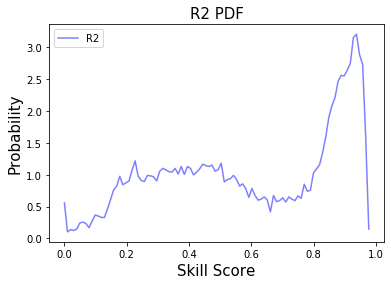

In [32]:
def pdf_gen(feat, names):
    maxi = 10.0
    bins = 100
    freq, edges = np.histogram(feat, bins, density=True)
    
    fig, ax = plt.subplots()

    plt.plot(edges[:-1], freq,  label = "R2", alpha = 0.5, color = 'blue')
    plt.xlabel('Skill Score', fontsize = 15)
    plt.ylabel('Probability', fontsize = 15)
    plt.title('R2 PDF', fontsize = 15)
    plt.legend(loc = 'best')
    #plt.xscale('log')
    #plt.yscale('log')

title = "R2 PDF"    
pdf_gen(R_surface, title)

## Averaged Points to Single Time Graph

Make a single plot for the global surface

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


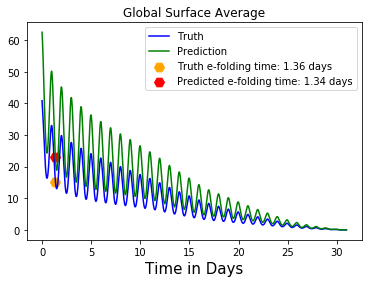

In [33]:
global_truth = np.squeeze(corr_truth[:,:,:,-1])
global_truth = np.nanmean(global_truth, axis = 0)
global_truth = np.nanmean(global_truth, axis = 0)

global_pred = np.squeeze(corr_pred[:,:,:,-1])
global_pred = np.nanmean(global_pred, axis = 0)
global_pred = np.nanmean(global_pred, axis = 0)

title = 'Global Surface Average'
truth_test = AutoCorr_Point(global_truth)
pred_test = AutoCorr_Point(global_pred)
Signal_Test(truth_test, pred_test, title)

In [34]:
def Signal_Test_Comp_Truth(point_a, point_b, point_c, title_a, title_b, title_c, title):
    fig, ax = plt.subplots()
    plt.title(title)
    tcoor = np.arange(0, len(point_b), 1)/96
    plt.plot(tcoor, point_a, label="All", color = 'blue')
    plt.plot(tcoor, point_b, label = "UnSkillful", color = 'green')
    plt.plot(tcoor, point_c, label = "Skillful", color = 'purple')
    
    it = np.argwhere(np.diff(np.sign(point_a/point_a[0]-np.exp(-1))))[0]
    tau = tcoor[it]
    plt.scatter(tau, np.exp(-1)*point_a[0], s=100, marker = 'H', color = 'blue', label=title_a+": "+str(round(tau[0],2))+' days')
    
    it = np.argwhere(np.diff(np.sign(point_b/point_b[0]-np.exp(-1))))[0]
    tau = tcoor[it]
    plt.scatter(tau, np.exp(-1)*point_b[0], s=100, marker = 'H', color = 'green', label=title_b+": "+str(round(tau[0],2))+' days')
    
    it = np.argwhere(np.diff(np.sign(point_c/point_c[0]-np.exp(-1))))[0]
    tau = tcoor[it]
    plt.scatter(tau, np.exp(-1)*point_c[0], s=100, marker = 'H', color = 'purple', label=title_c+": "+str(round(tau[0],2))+' days')
    
    plt.legend()
    plt.xlabel("Time in Days", fontsize = 15)
    plt.xlim(0, 0.35)
    plt.show()
    plt.close()

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


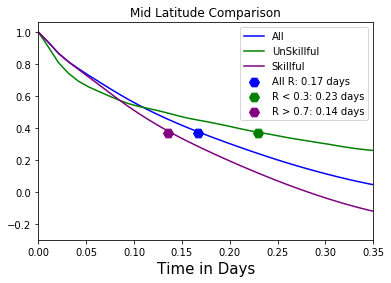

In [35]:
all_points = np.squeeze(midlat_truths[:,:,:,-1])
all_points = np.nanmean(all_points, axis = 0)
all_points = np.nanmean(all_points, axis = 0)

bad_points = np.squeeze(bad_midlats_truths[:,:,:,-1])
bad_points = np.nanmean(bad_points, axis = 0)
bad_points = np.nanmean(bad_points, axis = 0)

good_points = np.squeeze(good_midlats_truths[:,:,:,-1])
good_points = np.nanmean(good_points, axis = 0)
good_points = np.nanmean(good_points, axis = 0)

titles = 'Mid Latitude Comparison'
regions = "Mid Lats"
title_1 = 'All R'
title_2 = 'R < 0.3' 
title_3 = 'R > 0.7'
truth_test = AutoCorr_Point(global_truth)
pred_test = AutoCorr_Point(global_pred)
Signal_Test_Comp_Truth(all_points/np.max(all_points), bad_points/np.max(bad_points), good_points/np.max(good_points), title_1, title_2, title_3, titles)

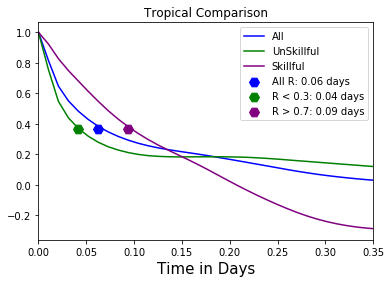

In [36]:
all_points = np.squeeze(tropical_truths[:,:,:,-1])
all_points = np.nanmean(all_points, axis = 0)
all_points = np.nanmean(all_points, axis = 0)

bad_points = np.squeeze(bad_tropical_truths[:,:,:,-1])
bad_points = np.nanmean(bad_points, axis = 0)
bad_points = np.nanmean(bad_points, axis = 0)

good_points = np.squeeze(good_tropical_truths[:,:,:,-1])
good_points = np.nanmean(good_points, axis = 0)
good_points = np.nanmean(good_points, axis = 0)

titles = 'Tropical Comparison'
truth_test = AutoCorr_Point(global_truth)
pred_test = AutoCorr_Point(global_pred)
Signal_Test_Comp_Truth(all_points/np.max(all_points), bad_points/np.max(bad_points), good_points/np.max(good_points), title_1, title_2, title_3, titles)

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


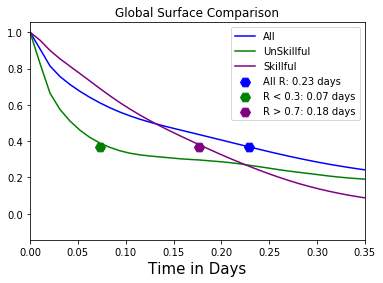

In [37]:
all_points = np.squeeze(corr_truth[:,:,:,-1])
all_points = np.nanmean(all_points, axis = 0)
all_points = np.nanmean(all_points, axis = 0)

bad_points = np.squeeze(all_bad_truths[:,:,:,-1])
bad_points = np.nanmean(bad_points, axis = 0)
bad_points = np.nanmean(bad_points, axis = 0)

good_points = np.squeeze(all_good_truths[:,:,:,-1])
good_points = np.nanmean(good_points, axis = 0)
good_points = np.nanmean(good_points, axis = 0)

titles = 'Global Surface Comparison'
regions = " Global"
truth_test = AutoCorr_Point(global_truth)
pred_test = AutoCorr_Point(global_pred)
Signal_Test_Comp_Truth(all_points/np.max(all_points), bad_points/np.max(bad_points), good_points/np.max(good_points), title_1, title_2, title_3, titles)

In [38]:
def percentile_gen(data_array, R_array):
    poor_output_array = np.zeros(shape=(x, len(data_array[0]),t))
    poor_output_array[:,:,:] = np.nan
    good_output_array = np.zeros(shape=(x, len(data_array[0]),t))
    good_output_array[:,:,:] = np.nan
    ten = np.nanpercentile(R_array, 10)
    ninty = np.nanpercentile(R_array, 90)
    good_count = 0
    bad_count = 0
    for i in range(len(data_array)):
        for j in range(len(data_array[i])):
                if R_array[i,j] >= ninty:
                    good_output_array[i,j,:]=data_array[i,j,:]
                    good_count = good_count+1
                
                if R_array[i,j] <= ten:
                    poor_output_array[i,j,:]=data_array[i,j,:]
                    bad_count = bad_count+1
     
    print("Skilled Count is:", good_count, "Unskilled Count is:", bad_count, "Total_Count is:", 144*len(data_array[0]))
    return good_output_array, poor_output_array

good_tropical_truths, bad_tropical_truths = percentile_gen(np.squeeze(tropical_truths[:,:,:,-1]), np.squeeze(np.squeeze(Tropical_R)[:,:,-1]))
good_tropical_preds, bad_tropical_preds = percentile_gen(np.squeeze(tropical_preds[:,:,:,-1]), np.squeeze(np.squeeze(Tropical_R)[:,:,-1]))
good_midlats_truths, bad_midlats_truths = percentile_gen(np.squeeze(midlat_truths[:,:,:,-1]),np.squeeze(np.squeeze(Mid_R)[:,:,-1]))
good_midlats_preds, bad_midlats_preds = percentile_gen(np.squeeze(midlat_preds[:,:,:,-1]), np.squeeze(np.squeeze(Mid_R)[:,:,-1]))
all_good_truths, all_bad_truths = percentile_gen(np.squeeze(corr_truth[:,:,:,-1]), np.squeeze(np.squeeze(R2)[:,:,-1]))
all_good_preds, all_bad_preds = percentile_gen(np.squeeze(corr_pred[:,:,:,-1]), np.squeeze(np.squeeze(R2)[:,:,-1]))

Skilled Count is: 216 Unskilled Count is: 216 Total_Count is: 2160
Skilled Count is: 216 Unskilled Count is: 216 Total_Count is: 2160
Skilled Count is: 231 Unskilled Count is: 231 Total_Count is: 2304
Skilled Count is: 231 Unskilled Count is: 231 Total_Count is: 2304
Skilled Count is: 1383 Unskilled Count is: 1383 Total_Count is: 13824
Skilled Count is: 1383 Unskilled Count is: 1383 Total_Count is: 13824


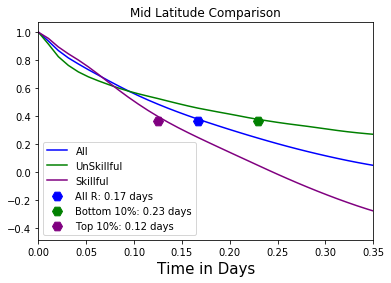

In [39]:
all_points = np.squeeze(midlat_truths[:,:,:,-1])
all_points = np.nanmean(all_points, axis = 0)
all_points = np.nanmean(all_points, axis = 0)

bad_points = np.nanmean(bad_midlats_truths, axis = 0)
bad_points = np.nanmean(bad_points, axis = 0)

good_points = np.nanmean(good_midlats_truths, axis = 0)
good_points = np.nanmean(good_points, axis = 0)

titles = 'Mid Latitude Comparison'
regions = "Mid Lats"
title_1 = 'All R'
title_2 = 'Bottom 10%' 
title_3 = 'Top 10%'
truth_test = AutoCorr_Point(global_truth)
pred_test = AutoCorr_Point(global_pred)
Signal_Test_Comp_Truth(all_points/np.max(all_points), bad_points/np.max(bad_points), good_points/np.max(good_points), title_1, title_2, title_3, titles)

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


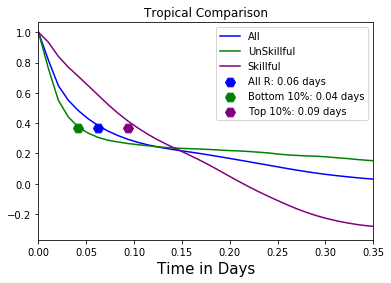

In [40]:
all_points = np.squeeze(tropical_truths[:,:,:,-1])
all_points = np.nanmean(all_points, axis = 0)
all_points = np.nanmean(all_points, axis = 0)

bad_points = np.nanmean(bad_tropical_truths, axis = 0)
bad_points = np.nanmean(bad_points, axis = 0)

good_points = np.nanmean(good_tropical_truths, axis = 0)
good_points = np.nanmean(good_points, axis = 0)

titles = 'Tropical Comparison'
regions = "Tropics"
truth_test = AutoCorr_Point(global_truth)
pred_test = AutoCorr_Point(global_pred)
Signal_Test_Comp_Truth(all_points/np.max(all_points), bad_points/np.max(bad_points), good_points/np.max(good_points), title_1, title_2, title_3, titles)

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


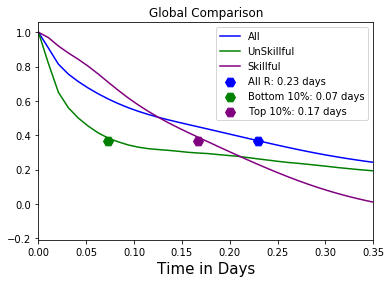

In [41]:
all_points = np.squeeze(corr_truth[:,:,:,-1])
all_points = np.nanmean(all_points, axis = 0)
all_points = np.nanmean(all_points, axis = 0)

bad_points = np.nanmean(all_bad_truths, axis = 0)
bad_points = np.nanmean(bad_points, axis = 0)

good_points = np.nanmean(all_good_truths, axis = 0)
good_points = np.nanmean(good_points, axis = 0)

titles = 'Global Comparison'
regions = "Global Surface"
truth_test = AutoCorr_Point(global_truth)
pred_test = AutoCorr_Point(global_pred)
Signal_Test_Comp_Truth(all_points/np.max(all_points), bad_points/np.max(bad_points), good_points/np.max(good_points), title_1, title_2, title_3, titles)

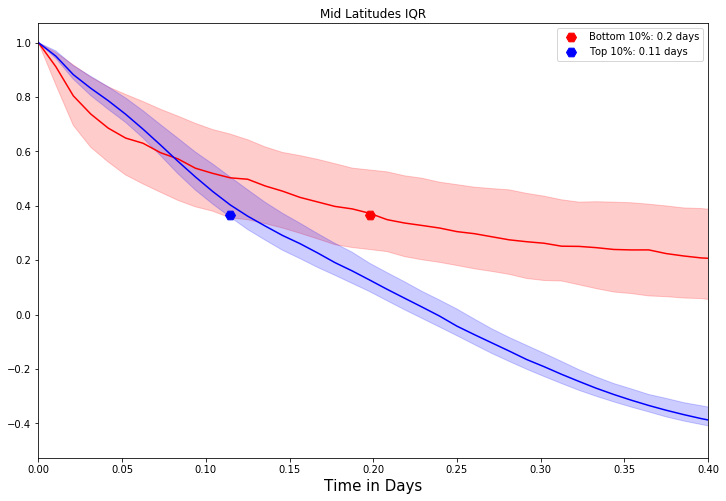

In [42]:
def stats_gen(datas):
    q1 = []
    median = []
    q3 = []
    for i in range(len(datas[0][0])):
        temp = np.squeeze(datas[:,:,i])
        temp = temp.ravel()
        q1.append(np.nanpercentile(temp, 25))
        median.append(np.nanpercentile(temp, 50))
        q3.append(np.nanpercentile(temp, 75))
    
    q1 = np.array(q1)
    median = np.array(median)
    q3 = np.array(q3)
    
    return q1/np.max(median), median/np.max(median), q3/np.max(median)

def Sig_Test(point_b):
    tcoor = np.arange(0, len(point_b), 1)/96
    it = np.argwhere(np.diff(np.sign(point_b/point_b[0]-np.exp(-1))))[0]
    tau = tcoor[it]
    return tau[0]

def e_time_getter(data_array):
    e_times = np.zeros(shape = (x, y))
    e_times[:,:] = np.nan
    for i in range(len(data_array)):
        for j in range(len(data_array[i])):
            temp = np.squeeze(data_array[i,j,:])
            value =  Sig_Test(temp)
            e_times[i,j] = value
            
    e_data = e_times.ravel()
    filtered_data = e_data[~np.isnan(e_data)]
    return filtered_data

def plot_stats(all_array, bad_array, good_array, title):
    labels = ["All R", "Bottom 10%", "Top 10%"]
    names = ["All","Unskillful","Skillful"]
    colors = ["purple","red","blue"]
    datas = [all_array, bad_array, good_array]
    #filtered_data = e_time_getter(datas[1])
    #plt.boxplot(filtered_data)
    fig, ax = plt.subplots(figsize = (12,8))
    plt.title(title+ " IQR")
    for i in range(len(labels)):
        q1, median, q3 = stats_gen(datas[i])
        tcoor = np.arange(0, len(median), 1)/96
        if i > 0:
            #lower_bound = plt.plot(tcoor, q1, color = colors[i], linestyle='--', dashes=(5, 8), alpha=0.8)
            #upper_bound = plt.plot(tcoor, q3, color = colors[i], linestyle='--', dashes=(5, 10), alpha = 0.8)
            y = plt.plot(tcoor, median, color = colors[i])
            plt.fill_between(tcoor, q1,  q3, alpha = 0.2, color = colors[i])
            it = np.argwhere(np.diff(np.sign(median/median[0]-np.exp(-1))))[0]
            tau = tcoor[it]
            plt.scatter(tau, np.exp(-1)*median[0], s=100, marker = 'H', color = colors[i], label=labels[i]+": "+str(round(tau[0],2))+' days')
    
   
    
    plt.legend()
    plt.xlabel("Time in Days", fontsize = 15)
    plt.xlim(0, 0.40)
    plt.show()
    plt.close()
    
plot_stats(np.squeeze(midlat_truths[:,:,:,-1]), bad_midlats_truths, good_midlats_truths, "Mid Latitudes")
np.save("/fast/gmooers/Real_Geography_Manuscript/Improved_Data_For_Paper/Final_SHERPA_Autocorr_Midlat_All.npy", np.squeeze(midlat_truths[:,:,:,-1]))
np.save("/fast/gmooers/Real_Geography_Manuscript/Improved_Data_For_Paper/Final_SHERPA_Autocorr_Midlat_bad.npy", bad_midlats_truths)
np.save("/fast/gmooers/Real_Geography_Manuscript/Improved_Data_For_Paper/Final_SHERPA_Autocorr_Midlat_good.npy", good_midlats_truths)

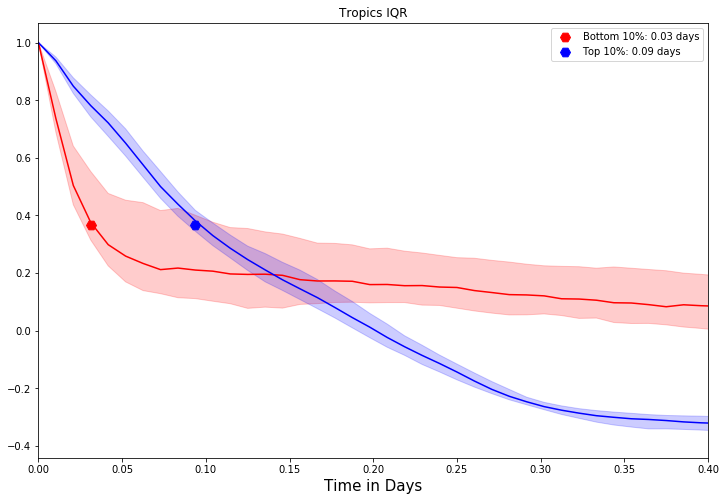

In [43]:
plot_stats(np.squeeze(tropical_truths[:,:,:,-1]), bad_tropical_truths, good_tropical_truths, "Tropics")
np.save("/fast/gmooers/Real_Geography_Manuscript/Improved_Data_For_Paper/Final_SHERPA_Autocorr_Tropical_All.npy", np.squeeze(tropical_truths[:,:,:,-1]))
np.save("/fast/gmooers/Real_Geography_Manuscript/Improved_Data_For_Paper/Final_SHERPA_Autocorr_Tropical_bad.npy", bad_tropical_truths)
np.save("/fast/gmooers/Real_Geography_Manuscript/Improved_Data_For_Paper/Final_SHERPA_Autocorr_Tropical_good.npy", good_tropical_truths)

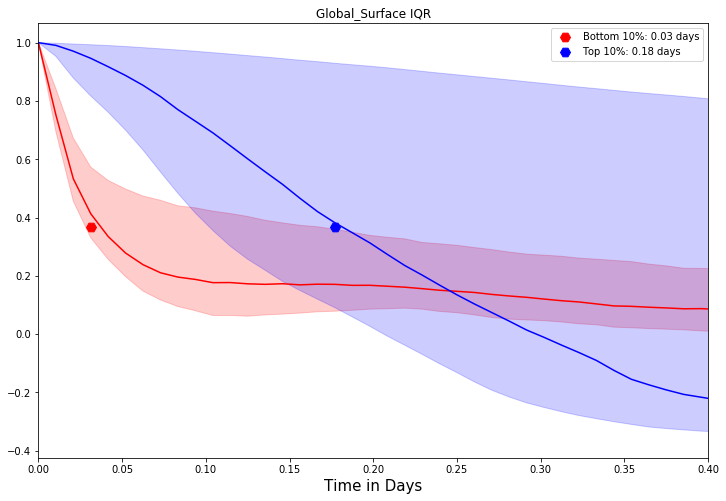

Global surface Preserved


In [44]:
plot_stats(np.squeeze(corr_truth[:,:,:,-1]), all_bad_truths, all_good_truths, "Global_Surface")
np.save("/fast/gmooers/Real_Geography_Manuscript/Improved_Data_For_Paper/Final_SHERPA_Autocorr_Surface_All.npy", np.squeeze(corr_truth[:,:,:,-1]))
np.save("/fast/gmooers/Real_Geography_Manuscript/Improved_Data_For_Paper/Final_SHERPA_Autocorr_Surface_bad.npy", all_bad_truths)
np.save("/fast/gmooers/Real_Geography_Manuscript/Improved_Data_For_Paper/Final_SHERPA_Autocorr_Surface_good.npy", all_good_truths)
print("Global surface Preserved")

## Latitude Longitude Maps

In [45]:
def Sig_Test(point_b):
    tcoor = np.arange(0, len(point_b), 1)/96
    it = np.argwhere(np.diff(np.sign(point_b/point_b[0]-np.exp(-1))))[0]
    tau = tcoor[it]
    return tau[0]

def e_time_getter(data_array):
    e_times = np.zeros(shape = (x, y, z))
    e_times[:,:,:] = np.nan
    for i in range(len(data_array)):
        for j in range(len(data_array[i])):
            for k in range(len(data_array[i][j][0])):
                temp = np.squeeze(data_array[i,j,:,k])
                value =  Sig_Test(temp)
                e_times[i,j,k] = value
    
    return e_times

In [46]:
pred_global_e = e_time_getter(corr_pred)
truth_global_e = e_time_getter(corr_truth)

others = netCDF4.Dataset("/fast/gmooers/Raw_Data/extras/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-72000.nc")
lons = np.array(others.variables['lon'])
lats = np.array(others.variables['lat'])
Xvar, Yvar = np.meshgrid(lons, lats)

In [47]:
freq_corr_truth = 1/corr_truth
freq_corr_pred = 1/corr_pred

freq_e_truth = 1/truth_global_e
freq_e_pred = 1/pred_global_e

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


Auto correlation plots

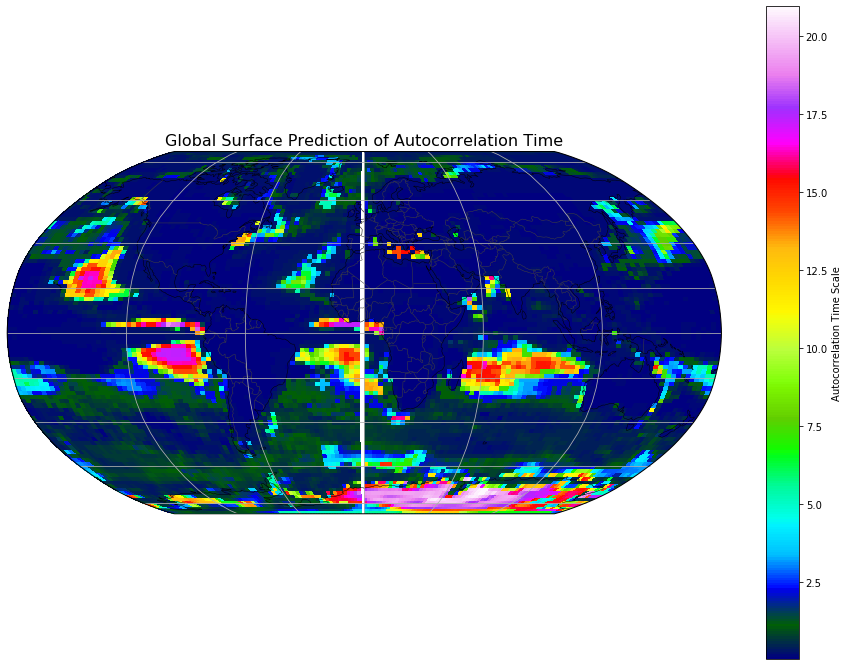

In [48]:
fig, ax1 = plt.subplots(1,1,subplot_kw={'projection':ccrs.Robinson()})
fig.set_size_inches(16,12)
contour_plot = ax1.pcolormesh(Xvar, Yvar, np.squeeze(pred_global_e[:,:,-1]).T,cmap='gist_ncar', transform=ccrs.PlateCarree())
plt.colorbar(contour_plot, label = "Autocorrelation Time Scale")
ax1.set_title('Global Surface Prediction of Autocorrelation Time')
ax1.title.set_fontsize(16)
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

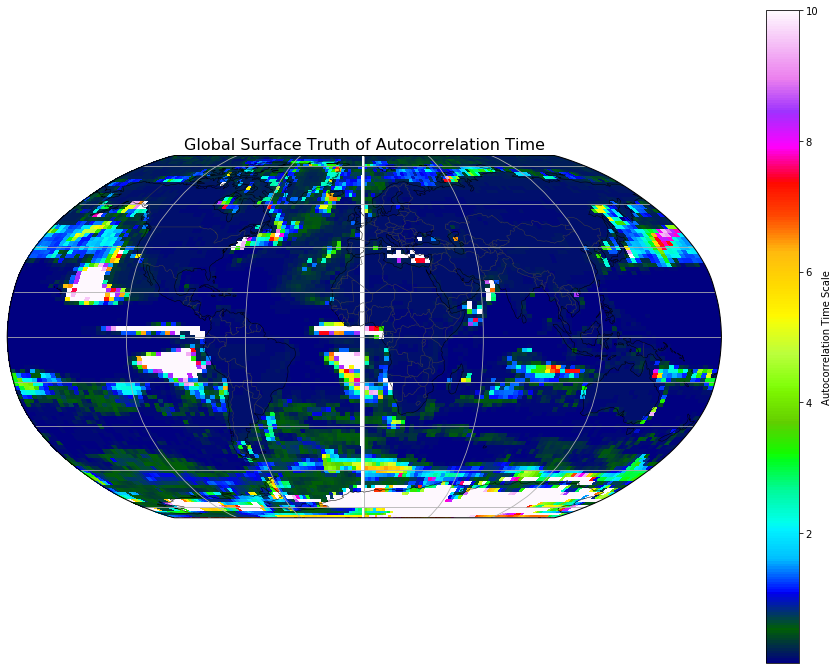

In [49]:
fig, ax1 = plt.subplots(1,1,subplot_kw={'projection':ccrs.Robinson()})
fig.set_size_inches(16,12)
contour_plot = ax1.pcolormesh(Xvar, Yvar, np.squeeze(truth_global_e[:,:,-1]).T,cmap='gist_ncar', vmax = 10.0, transform=ccrs.PlateCarree())
plt.colorbar(contour_plot, label = "Autocorrelation Time Scale")
ax1.set_title('Global Surface Truth of Autocorrelation Time')
ax1.title.set_fontsize(16)
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

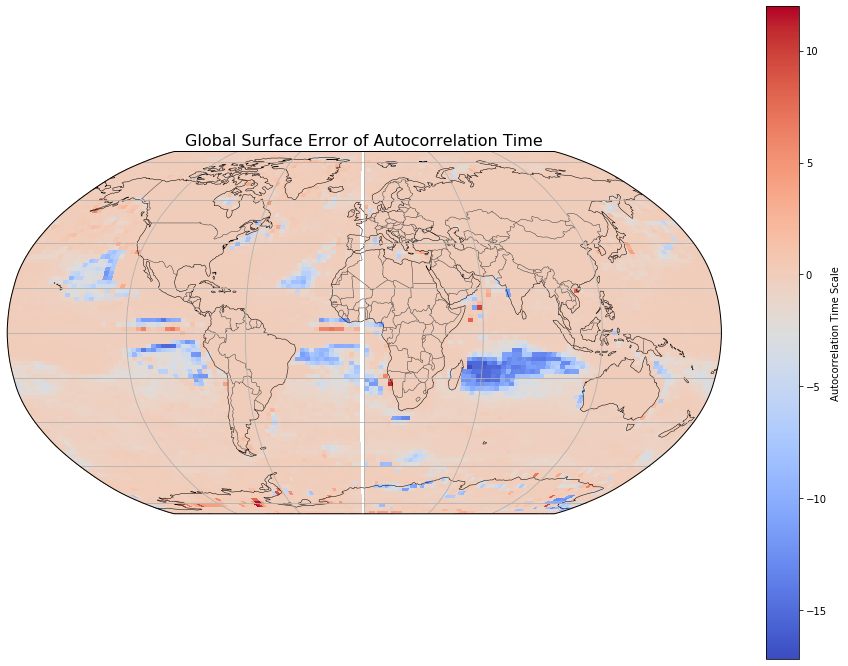

In [50]:
auto_corr_error = truth_global_e - pred_global_e
fig, ax1 = plt.subplots(1,1,subplot_kw={'projection':ccrs.Robinson()})
fig.set_size_inches(16,12)
contour_plot = ax1.pcolormesh(Xvar, Yvar, np.squeeze(auto_corr_error[:,:,-1]).T,cmap='coolwarm', transform=ccrs.PlateCarree())
plt.colorbar(contour_plot, label = "Autocorrelation Time Scale")
ax1.set_title('Global Surface Error of Autocorrelation Time')
ax1.title.set_fontsize(16)
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


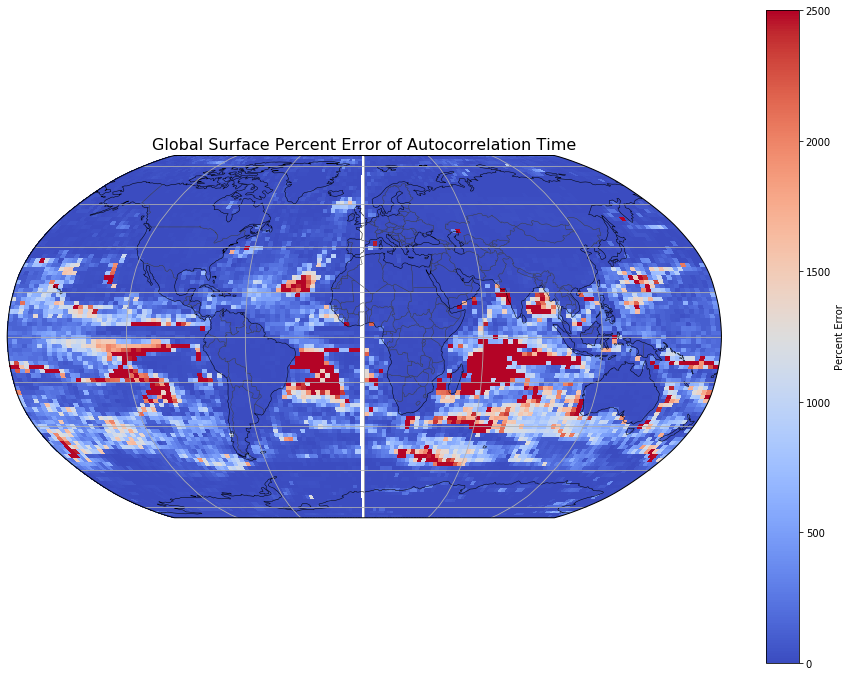

In [51]:
percent_auto_corr_error = 100.0*np.abs(truth_global_e - pred_global_e)/truth_global_e
fig, ax1 = plt.subplots(1,1,subplot_kw={'projection':ccrs.Robinson()})
fig.set_size_inches(16,12)
contour_plot = ax1.pcolormesh(Xvar, Yvar, np.squeeze(percent_auto_corr_error[:,:,-1]).T,cmap='coolwarm', vmax = 2500, transform=ccrs.PlateCarree())
plt.colorbar(contour_plot, label = "Percent Error")
ax1.set_title('Global Surface Percent Error of Autocorrelation Time')
ax1.title.set_fontsize(16)
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

Frequency Plots

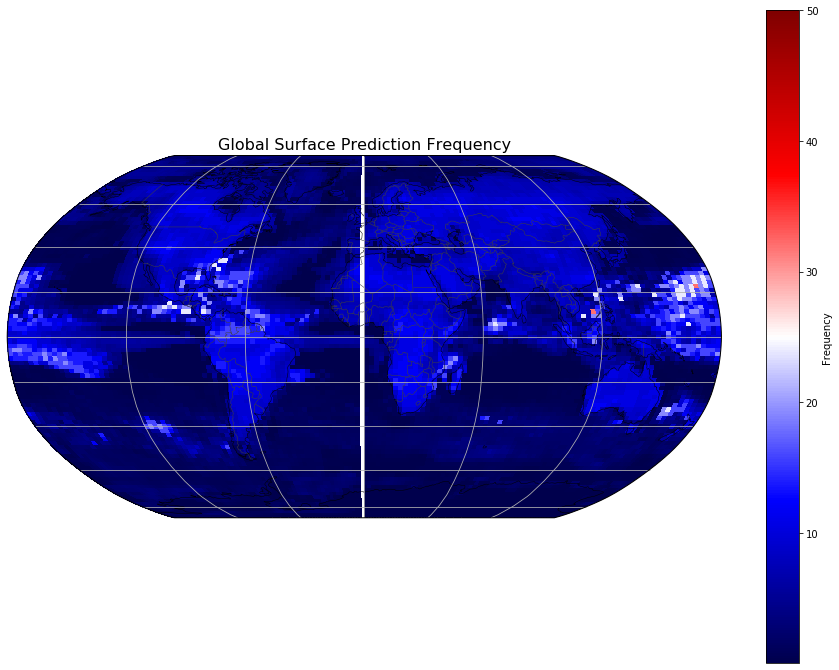

In [52]:
fig, ax1 = plt.subplots(1,1,subplot_kw={'projection':ccrs.Robinson()})
fig.set_size_inches(16,12)
contour_plot = ax1.pcolormesh(Xvar, Yvar, np.squeeze(freq_e_pred[:,:,-1]).T,cmap='seismic', vmax = 50, transform=ccrs.PlateCarree())
plt.colorbar(contour_plot, label = "Frequency")
ax1.set_title('Global Surface Prediction Frequency')
ax1.title.set_fontsize(16)
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

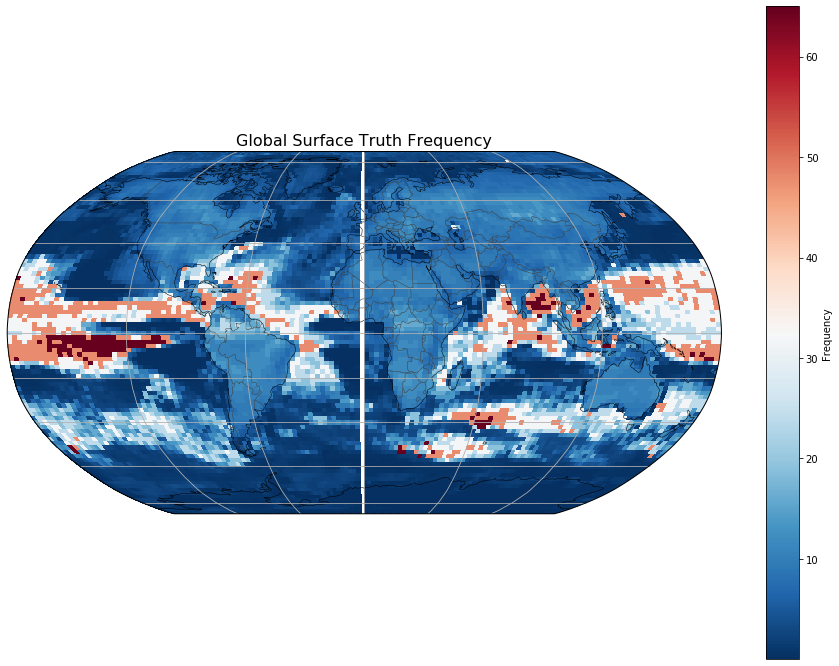

In [53]:
fig, ax1 = plt.subplots(1,1,subplot_kw={'projection':ccrs.Robinson()})
fig.set_size_inches(16,12)
contour_plot = ax1.pcolormesh(Xvar, Yvar, freq_e_truth[:,:,-1].T,cmap="RdBu_r", vmax = 65, transform=ccrs.PlateCarree())
plt.colorbar(contour_plot, label = "Frequency")
ax1.set_title('Global Surface Truth Frequency')
ax1.title.set_fontsize(16)
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
np.save("/fast/gmooers/Real_Geography_Manuscript/Improved_Data_For_Paper/Final_SHERPA_Autocorr_SFC_Frequency.npy",np.squeeze(freq_e_truth[:,:,-1].T))

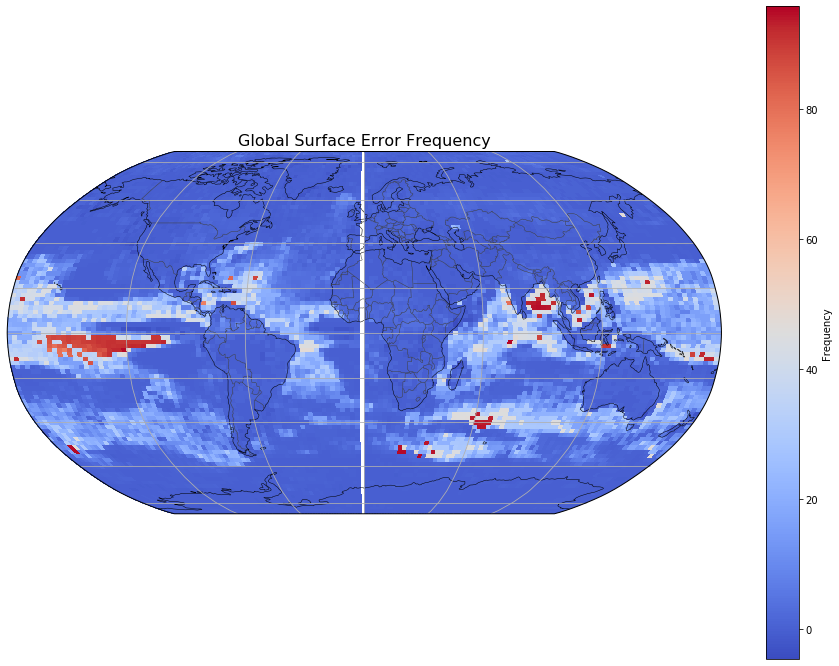

In [54]:
error = freq_e_truth - freq_e_pred
fig, ax1 = plt.subplots(1,1,subplot_kw={'projection':ccrs.Robinson()})
fig.set_size_inches(16,12)
contour_plot = ax1.pcolormesh(Xvar, Yvar, error[:,:,-1].T,cmap='coolwarm', transform=ccrs.PlateCarree())
plt.colorbar(contour_plot, label = "Frequency")
ax1.set_title('Global Surface Error Frequency')
ax1.title.set_fontsize(16)
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


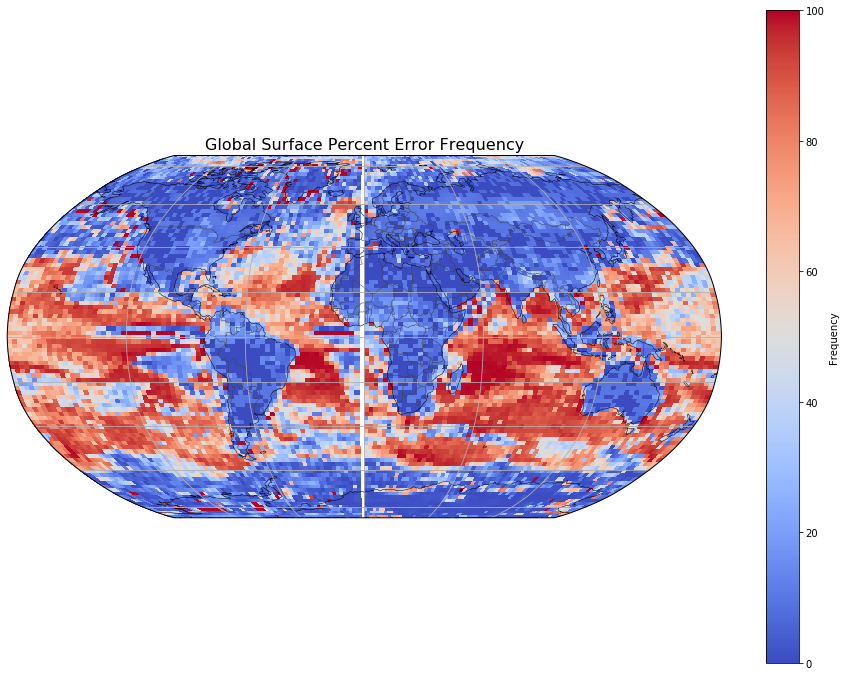

In [55]:
percent_error = 100.0*np.abs(freq_e_truth - freq_e_pred)/freq_e_truth
fig, ax1 = plt.subplots(1,1,subplot_kw={'projection':ccrs.Robinson()})
fig.set_size_inches(16,12)
contour_plot = ax1.pcolormesh(Xvar, Yvar, percent_error[:,:,-1].T,cmap='coolwarm', vmax = 100, transform=ccrs.PlateCarree())
plt.colorbar(contour_plot, label = "Frequency")
ax1.set_title('Global Surface Percent Error Frequency')
ax1.title.set_fontsize(16)
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

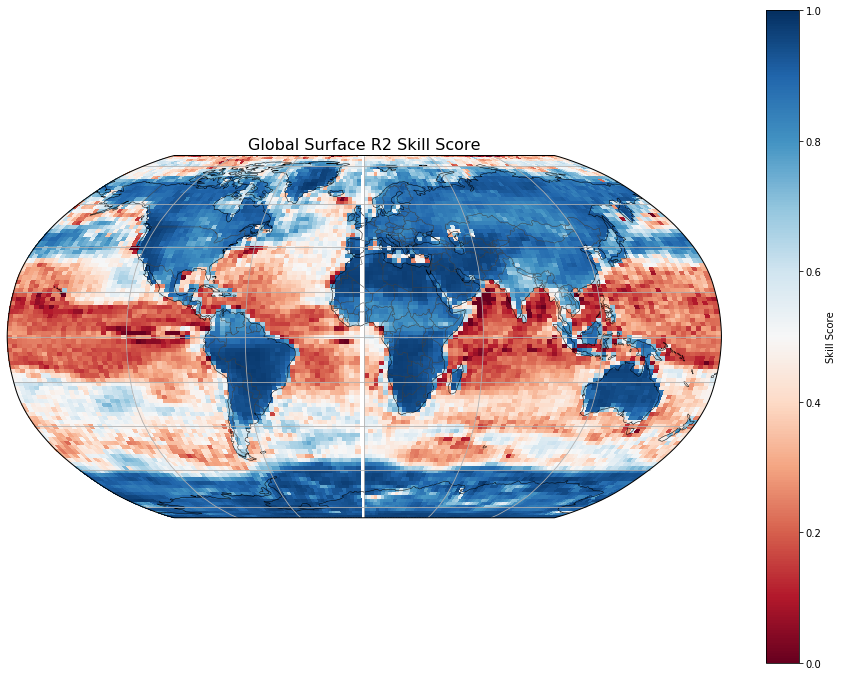

In [56]:
fig, ax1 = plt.subplots(1,1,subplot_kw={'projection':ccrs.Robinson()})
fig.set_size_inches(16,12)
contour_plot = ax1.pcolormesh(Xvar, Yvar, np.squeeze(R2)[:,:,-1].T,cmap='RdBu', vmin = 0, vmax = 1.0, transform=ccrs.PlateCarree())
plt.colorbar(contour_plot, label = "Skill Score")
ax1.set_title('Global Surface R2 Skill Score')
ax1.title.set_fontsize(16)
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
np.save("/fast/gmooers/Real_Geography_Manuscript/Improved_Data_For_Paper/Final_SHERPA_Premade_Lat_Lon_R2_Error.npy",np.squeeze(R2)[:,:,-1].T)

## pattern with Precipiation

In [57]:
path_to_file = '/fast/gmooers/Preprocessed_Data/Final_July/full_physics_essentials_test_month02_targets.nc'
extra_variables = xr.open_dataset(path_to_file)
precips = extra_variables.targets[:,-1].values
precips = precips*86400.0

FileNotFoundError: [Errno 2] No such file or directory: b'/fast/gmooers/Preprocessed_Data/Final_July/full_physics_essentials_test_month02_targets.nc'

In [ ]:
precip= np.zeros(shape=(x, y, t))
precip[:,:,:] = np.nan

count = 0
for i in range(t):
    for j in range(y):
        for k in range(x):
            A = precips[count]
            precip[k, j, i] = A
            count = count+1

In [ ]:
precip_plot = np.squeeze(np.nanmean(precip, axis=2))

In [ ]:
fig, ax1 = plt.subplots(1,1,subplot_kw={'projection':ccrs.Robinson()})
fig.set_size_inches(16,12)
contour_plot = ax1.pcolormesh(Xvar, Yvar, precip_plot.T,cmap='RdBu_r', vmax = 0.010, transform=ccrs.PlateCarree())
plt.colorbar(contour_plot, label = "mm/day")
ax1.set_title('Global Precipiatation Pattern')
ax1.title.set_fontsize(16)
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

## Scatter plots

In [ ]:
sfc_R = np.squeeze(np.squeeze(R2)[:,:,-1])

In [ ]:
b = sfc_R
a = np.squeeze(freq_e_truth[:,:,-1])
title = "Surface R2 vs. Surface Truth Autocorr Frequency "
plt.scatter(np.reshape(a, (a.size,)), np.reshape(b, (b.size,)), s = 0.01)
plt.ylabel("R2 Skill Score")
plt.xlabel("Autocorr Frequency")
plt.ylim(0,1)
plt.title(title)
plt.show()
plt.close()

In [ ]:
b = sfc_R
a = np.squeeze(freq_e_truth[:,:,-1])
title = "Surface R2 vs. Surface Truth Autocorr Frequency "
plt.scatter(np.reshape(a, (a.size,)), np.reshape(b, (b.size,)), s = 0.01)
plt.ylabel("R2 Skill Score")
plt.xlabel("Autocorr Frequency")
plt.xscale('log')
plt.yscale('log')
plt.title(title)
plt.show()
plt.close()

Try only the log(R2) vs. Autocorr frequency

In [ ]:
b = sfc_R
a = np.squeeze(freq_e_truth[:,:,-1])
title = "Surface R2 vs. Surface Truth Autocorr Frequency "
plt.scatter(np.reshape(a, (a.size,)), np.reshape(b, (b.size,)), s = 0.01)
plt.ylabel("R2 Skill Score")
plt.xlabel("Autocorr Frequency")
#plt.xscale('log')
plt.yscale('log')
plt.title(title)
plt.show()
plt.close()

Condition mean and standard devation from information above

In [ ]:
b = sfc_R
a = np.squeeze(freq_e_truth[:,:,-1])

x_data = np.reshape(a, (a.size,))
y_data = np.reshape(b, (b.size,))

In [ ]:
def stats_gen_two(x_datas, y_datas):
    uniques = np.unique(x_datas)
    means = np.zeros(shape=(len(uniques)))
    means[:] = np.nan
    std = np.zeros(shape=(len(uniques)))
    std[:] = np.nan
    temp_list = []
    
    stat_counter = 0
    for a in range(len(uniques)):
        for i in range(len(x_datas)):
            if uniques[a] == x_datas[i]:
                temp_list.append(y_datas[i])
            
        means[a] = statistics.mean(temp_list)
        if len(temp_list) > 1:
            std[a] = statistics.stdev(temp_list)
        temp_list = []
    
    return means, uniques, std
            
    
means, uniques, std = stats_gen_two(x_data, y_data) 

Apply a line of best fit to this Graph?

https://scipy-lectures.org/intro/scipy/auto_examples/plot_curve_fit.html

In [ ]:
def e_value():
    e_number = sum(1 / float(math.factorial(i)) for i in range(10))
    return e_number

In [ ]:
def test_func(x_values, a, b):
    e_number = e_value()
    #output = a*(1.0-(e_number**(b*x_values)))
    output = a*(b**x_values)
    #output = -1.0*a*x_values + b
    return output

In [ ]:
x_dat = uniques
y_dat = means
params, params_covariance = curve_fit(test_func, x_dat, y_dat, p0=[0.1, 0.9])

print(params)

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(x_dat, y_dat,  s = 0.1)
plt.plot(x_dat, test_func(x_dat,  params[0], params[1]), label='Fitted function', color = 'orange')
plt.legend(loc='best')
plt.xlabel('Frequency')
#plt.yscale('log')
plt.ylabel('R2 Skill Score')
plt.show()

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(x_dat, y_dat,  s = 0.1)
plt.plot(x_dat, test_func(x_dat,  params[0], params[1]), label='Fitted function', color = 'orange')
plt.legend(loc='best')
plt.xlabel('Frequency')
plt.yscale('log')
plt.ylabel('R2 Skill Score')
plt.show()

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(x_dat, y_dat,  s = 0.1)
plt.plot(x_dat, test_func(x_dat,  params[0], params[1]), label='Fitted function', color = 'orange')
plt.legend(loc='best')
plt.xlabel('Frequency')
plt.ylabel('R2 Skill Score')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
#from DeGaetano, Mooers, and Favata 2020

from scipy.optimize import curve_fit
Grid_list = [0.18118466898954705, 0.5432098765432098, 0.6190476190476191, 0.8166666666666667, 0.9705882352941178, 0.5357142857142857, 1.692307692307692, 1.0, 0.9090909090909091, 0.6470588235294117, 0.8, 1.2000000000000002, 1.6666666666666665, 2.0, 0.875, 0.4285714285714286, 1.0, 0.6000000000000001, 0.5, 0.6666666666666666, 1.0, 1.0, 2.5, 1.0, 1.0, 1.0, 0.2, 1.0, 0.2, 0.25, 4.0, 1.0, 3.0, 0.5, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

        
        
def line_fit(something):
    e_number = e_value()
    y = something
    x = np.arange(0, len(y), 1)
    for i in range(len(x)):
        x[i] = x[i]*50
    x = np.array(x, dtype=float) 
    y = np.array(y, dtype=float)
    
    def func(x, a, b, c):
        return a*(1-(e_number**(-b*x))) + c
        #return a * -np.exp(-b * x) + c
        
    guess = [0.1, 0.1, 0.1]

    popt, pcov = curve_fit(func, x, y, p0=guess)
    print(list(popt))
    print(' ')
    print(pcov)
   
    plt.plot(x, y, linestyle='--', marker='o', color='g')
    plt.plot(x, func(x, *popt), 'r-', linewidth = 4.0)
    plt.legend(["NRCC Interpolated over NRCC High Resolution (2002-2016)", "Fitted Curved"], loc='upper left')
      
    plt.title('Best Fit for Ratio of Events in NRCC Interpolated over NRCC High Resolution')
    plt.ylabel('Ratio of Extreme Precipitation Events detected')
    plt.xlabel('Events in 50 kilometer squared bins from 0-1000 kilomters squared')
    #plt.savefig('/Users/gm447/desktop/10_Log_1000')
    plt.show()

line_fit(Grid_list)

Try regional filters

Tropical

In [ ]:
b = sfc_R[:,40:55]
a = np.squeeze(freq_e_truth[:,40:55,-1])
title = "Tropical Surface R2 vs. Surface Truth Autocorr Frequency "
plt.scatter(np.reshape(a, (a.size,)), np.reshape(b, (b.size,)), s = 0.05)
plt.ylabel("R2 Skill Score")
plt.xlabel("Autocorr Frequency")
plt.ylim(0,1)
plt.xlim(0,100)
plt.title(title)
plt.show()
plt.close()

In [ ]:
b = sfc_R[:,40:55]
a = np.squeeze(freq_e_truth[:,40:55,-1])
title = "Tropical Surface R2 vs. Surface Truth Autocorr Frequency "
plt.scatter(np.reshape(a, (a.size,)), np.reshape(b, (b.size,)), s = 0.05)
plt.ylabel("R2 Skill Score")
plt.xlabel("Autocorr Frequency")
plt.xscale('log')
plt.yscale('log')
plt.title(title)
plt.show()
plt.close()

Mid Latitude

In [ ]:
b = sfc_R[:,64:80]
a = np.squeeze(freq_e_truth[:,64:80,-1])
title = "Midlat Surface R2 vs. Surface Truth Autocorr Frequency "
plt.scatter(np.reshape(a, (a.size,)), np.reshape(b, (b.size,)), s = 0.05)
plt.ylabel("R2 Skill Score")
plt.xlabel("Autocorr Frequency")
plt.ylim(0,1)
plt.title(title)
plt.xlim(0,100)
plt.show()
plt.close()

In [ ]:
b = sfc_R[:,64:80]
a = np.squeeze(freq_e_truth[:,64:80,-1])
title = "Midlat Surface R2 vs. Surface Truth Autocorr Frequency "
plt.scatter(np.reshape(a, (a.size,)), np.reshape(b, (b.size,)), s = 0.05)
plt.ylabel("R2 Skill Score")
plt.xlabel("Autocorr Frequency")
plt.xscale('log')
plt.yscale('log')
plt.title(title)
plt.show()
plt.close()

Try a land and ocean mask

Ocean Mask

In [ ]:
lat_list = np.linspace(-90.0, 90.0, 96)
lon_list = np.linspace(0.0, 357.5, 144)

land_freq_truth = np.zeros(shape=(x, y, z))
land_R2 = np.zeros(shape=(x, y, z))
land_freq_truth[:,:,:] = np.nan
land_R2[:,:,:] = np.nan

for i in range(len(land_freq_truth)):
    lon = lon_list[i]
    if lon > 180.0:
        lon = lon - 360.0
    for j in range(len(land_freq_truth[i])):
        lat = lat_list[j]
        if bm.is_land(lon, lat) == True:
            land_freq_truth[i, j, :] = freq_e_truth[i, j, :]
            land_R2[i, j, :] = R2[i, j, :]

In [ ]:
b = np.squeeze(land_R2[:,:,-1])
a = np.squeeze(land_freq_truth[:,:,-1])
title = "Land Surface R2 vs. Surface Truth Autocorr Frequency "
plt.scatter(np.reshape(a, (a.size,)), np.reshape(b, (b.size,)), s = 0.05)
plt.ylabel("R2 Skill Score")
plt.xlabel("Autocorr Frequency")
plt.xlim(0,100)
plt.ylim(0,1)
plt.title(title)
plt.show()
plt.close()

In [ ]:
b = np.squeeze(land_R2[:,:,-1])
a = np.squeeze(land_freq_truth[:,:,-1])
title = "Land Surface R2 vs. Surface Truth Autocorr Frequency "
plt.scatter(np.reshape(a, (a.size,)), np.reshape(b, (b.size,)), s = 0.05)
plt.ylabel("R2 Skill Score")
plt.xlabel("Autocorr Frequency")
plt.xscale('log')
plt.yscale('log')
plt.title(title)
plt.show()
plt.close()

Land Mask

In [ ]:
lat_list = np.linspace(-90.0, 90.0, 96)
lon_list = np.linspace(0.0, 357.5, 144)

ocean_freq_truth = np.zeros(shape=(x, y, z))
ocean_R2 = np.zeros(shape=(x, y, z))
ocean_freq_truth[:,:,:] = np.nan
ocean_R2[:,:,:] = np.nan

for i in range(len(ocean_freq_truth)):
    lon = lon_list[i]
    if lon > 180.0:
        lon = lon - 360.0
    for j in range(len(ocean_freq_truth[i])):
        lat = lat_list[j]
        if bm.is_land(lon, lat) == False:
            ocean_freq_truth[i, j, :] = freq_e_truth[i, j, :]
            ocean_R2[i, j, :] = R2[i, j, :]

In [ ]:
b = np.squeeze(ocean_R2[:,:,-1])
a = np.squeeze(ocean_freq_truth[:,:,-1])
title = "Ocean Surface R2 vs. Surface Truth Autocorr Frequency "
plt.scatter(np.reshape(a, (a.size,)), np.reshape(b, (b.size,)), s = 0.01)
plt.ylabel("R2 Skill Score")
plt.xlabel("Autocorr Frequency")
plt.xlim(0,100)
plt.ylim(0,1)
plt.title(title)
plt.show()
plt.close()

In [ ]:
b = np.squeeze(ocean_R2[:,:,-1])
a = np.squeeze(ocean_freq_truth[:,:,-1])
title = "Ocean Surface R2 vs. Surface Truth Autocorr Frequency "
plt.scatter(np.reshape(a, (a.size,)), np.reshape(b, (b.size,)), s = 0.01)
plt.ylabel("R2 Skill Score")
plt.xlabel("Autocorr Frequency")
plt.xscale('log')
plt.yscale('log')
plt.title(title)
plt.show()
plt.close()